# Keras Instruct Pix 2 Pix: GPU Example

Ported from https://github.com/huggingface/diffusers/blob/v0.13.0/src/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion_instruct_pix2pix.py

## Install Requirements

In [1]:
!pip install keras-cv protobuf==3.19 tensorflow==2.11.0

## Utils

In [2]:
import PIL
import requests
import numpy as np
from keras_cv.models.stable_diffusion import StableDiffusion
from keras_cv.models.stable_diffusion.diffusion_model import *
from keras_cv.models.stable_diffusion.text_encoder import TextEncoder
import tensorflow as tf
import tensorflow.keras as keras
from typing import Callable, List, Optional, Union
import math
import tqdm
from io import BytesIO

2023-02-24 16:44:56.211249: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-24 16:44:56.903796: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-02-24 16:44:56.903866: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-02-24 16:44:56.903873: W tensorfl

You do not have pycocotools installed, so KerasCV pycoco metrics are not available. Please run `pip install pycocotools`.
You do not have pyococotools installed, so the `PyCOCOCallback` API is not available.
You do not have Waymo Open Dataset installed, so KerasCV Waymo metrics are not available.


## Image Example

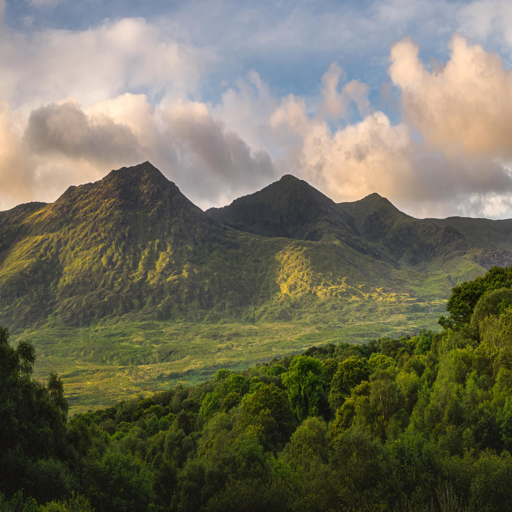

In [3]:
def download_image(url):
    response = requests.get(url)
    return PIL.Image.open(BytesIO(response.content)).convert("RGB")

img_url = "https://huggingface.co/datasets/diffusers/diffusers-images-docs/resolve/main/mountain.png"
image = download_image(img_url).resize((512, 512))

image

## Euler Ancestral Discrete Scheduler Implementation

In [4]:
# Ported from https://github.com/huggingface/diffusers/blob/v0.13.0/src/diffusers/schedulers/scheduling_euler_ancestral_discrete.py
class EulerAncestralDiscreteScheduler():
    order = 1
    
    def __init__(self, 
                 num_train_timesteps = 1000, 
                 beta_start: float = 0.00085, 
                 beta_end: float = 0.012, 
                 trained_betas: Optional[Union[np.ndarray, List[float]]] = None):
        # this schedule is very specific to the latent diffusion model.
        self.betas = (
            tf.linspace(beta_start**0.5, beta_end**0.5, num_train_timesteps) ** 2
        )
        
        self.alphas = 1.0 - self.betas
        self.alphas_cumprod = tf.math.cumprod(self.alphas, axis=0)
        
        sigmas = np.array(((1 - self.alphas_cumprod) / self.alphas_cumprod) ** 0.5)
        sigmas = np.concatenate([sigmas[::-1], [0.0]]).astype(np.float32)
        
        self.sigmas = tf.convert_to_tensor(sigmas)
        
        # standard deviation of the initial noise distribution
        self.init_noise_sigma = tf.reduce_max(self.sigmas)
        
        # setable values
        self.num_train_timesteps = num_train_timesteps
        self.num_inference_steps = None
        timesteps = np.linspace(0, num_train_timesteps - 1, num_train_timesteps, dtype=float)[::-1].copy()
        self.timesteps = tf.convert_to_tensor(timesteps)
        self.is_scale_input_called = False
        
    def scale_model_input(
        self, sample: tf.Tensor, timestep: Union[float, tf.Tensor]
    ):
        step_index = tf.where(self.timesteps == timestep).numpy()[0,0]
        sigma = self.sigmas[step_index]
        sample = sample / ((sigma**2 + 1) ** 0.5)
        self.is_scale_input_called = True
        return sample
    
    def set_timesteps(self, num_inference_steps: int):
        self.num_inference_steps = num_inference_steps
        timesteps = np.linspace(0, self.num_train_timesteps - 1, num_inference_steps, dtype=float)[::-1].copy()
        sigmas = np.array(((1 - self.alphas_cumprod) / self.alphas_cumprod) ** 0.5)
        sigmas = np.interp(timesteps, np.arange(0, len(sigmas)), sigmas)
        sigmas = np.concatenate([sigmas, [0.0]]).astype(np.float32)
        self.sigmas = tf.convert_to_tensor(sigmas)
        self.timesteps = tf.convert_to_tensor(timesteps)
        
    def step(
        self,
        model_output: tf.Tensor,
        timestep: Union[float, tf.Tensor],
        sample: tf.Tensor,
        generator: Optional[tf.Tensor] = None,
        return_dict: bool = True,
    ):
        step_index = tf.where(self.timesteps == timestep).numpy()[0,0]
        sigma = self.sigmas[step_index]
        
        # 1. compute predicted original sample (x_0) from sigma-scaled predicted noise
        pred_original_sample = sample - sigma * model_output
        
        sigma_from = self.sigmas[step_index]
        sigma_to = self.sigmas[step_index + 1]
        sigma_up = (sigma_to**2 * (sigma_from**2 - sigma_to**2) / sigma_from**2) ** 0.5
        sigma_down = (sigma_to**2 - sigma_up**2) ** 0.5
        
        # 2. Convert to an ODE derivative
        derivative = (sample - pred_original_sample) / sigma

        dt = sigma_down - sigma

        prev_sample = sample + derivative * dt
        
        noise = tf.random.normal( model_output.shape, dtype = model_output.dtype )
        
        prev_sample = prev_sample + noise * sigma_up
        
        return {
            "prev_sample": prev_sample, 
            "pred_original_sample": pred_original_sample
        }
    
    def add_noise(
        self,
        original_samples: tf.Tensor,
        noise: tf.Tensor,
        timesteps: tf.Tensor,
    ) -> tf.Tensor:
        
        schedule_timesteps = self.timesteps
        step_indices = [(schedule_timesteps == t).numpy()[0,0] for t in timesteps]
        
        sigma = self.sigmas[step_indices].flatten()
        
        while len(sigma.shape) < len(original_samples.shape):
            sigma = sigma.unsqueeze(-1)

        noisy_samples = original_samples + noise * sigma
        return noisy_samples
    
    def __len__(self):
        return self.num_train_timesteps
        

## Diffusion Model Implementation

In [5]:
# Edited from https://github.com/keras-team/keras-cv/blob/master/keras_cv/models/stable_diffusion
MAX_PROMPT_LENGTH = 77

def preprocess(image):
    if isinstance(image, tf.Tensor):
        return image
    elif isinstance(image, PIL.Image.Image):
        image = [image]

    if isinstance(image[0], PIL.Image.Image):
        w, h = image[0].size
        w, h = map(lambda x: x - x % 8, (w, h))  # resize to integer multiple of 8

        image = [np.array(i.resize((w, h), resample=PIL.Image.Resampling.LANCZOS))[None, :] for i in image]
        image = np.concatenate(image, axis=0)
        image = np.array(image).astype(np.float32) / 255.0
        image = 2.0 * image - 1.0
        image = tf.convert_to_tensor(image)
            
    elif isinstance(image[0], tf.Tensor):
        image = tf.concat(image, 0)
    return image

class DiffusionModelInstructPix2Pix(keras.Model):
    def __init__(
        self, img_height, img_width, max_text_length, name=None, download_weights=True
    ):
        context = keras.layers.Input((max_text_length, 768))
        t_embed_input = keras.layers.Input((320,))
        latent = keras.layers.Input((img_height // 8, img_width // 8, 8))

        t_emb = keras.layers.Dense(1280)(t_embed_input)
        t_emb = keras.layers.Activation("swish")(t_emb)
        t_emb = keras.layers.Dense(1280)(t_emb)

        # Downsampling flow

        outputs = []
        x = PaddedConv2D(320, kernel_size=3, padding=1)(latent)
        outputs.append(x)

        for _ in range(2):
            x = ResBlock(320)([x, t_emb])
            x = SpatialTransformer(8, 40, fully_connected=False)([x, context])
            outputs.append(x)
        x = PaddedConv2D(320, 3, strides=2, padding=1)(x)  # Downsample 2x
        outputs.append(x)

        for _ in range(2):
            x = ResBlock(640)([x, t_emb])
            x = SpatialTransformer(8, 80, fully_connected=False)([x, context])
            outputs.append(x)
        x = PaddedConv2D(640, 3, strides=2, padding=1)(x)  # Downsample 2x
        outputs.append(x)

        for _ in range(2):
            x = ResBlock(1280)([x, t_emb])
            x = SpatialTransformer(8, 160, fully_connected=False)([x, context])
            outputs.append(x)
        x = PaddedConv2D(1280, 3, strides=2, padding=1)(x)  # Downsample 2x
        outputs.append(x)

        for _ in range(2):
            x = ResBlock(1280)([x, t_emb])
            outputs.append(x)

        # Middle flow

        x = ResBlock(1280)([x, t_emb])
        x = SpatialTransformer(8, 160, fully_connected=False)([x, context])
        x = ResBlock(1280)([x, t_emb])

        # Upsampling flow

        for _ in range(3):
            x = keras.layers.Concatenate()([x, outputs.pop()])
            x = ResBlock(1280)([x, t_emb])
        x = Upsample(1280)(x)

        for _ in range(3):
            x = keras.layers.Concatenate()([x, outputs.pop()])
            x = ResBlock(1280)([x, t_emb])
            x = SpatialTransformer(8, 160, fully_connected=False)([x, context])
        x = Upsample(1280)(x)

        for _ in range(3):
            x = keras.layers.Concatenate()([x, outputs.pop()])
            x = ResBlock(640)([x, t_emb])
            x = SpatialTransformer(8, 80, fully_connected=False)([x, context])
        x = Upsample(640)(x)

        for _ in range(3):
            x = keras.layers.Concatenate()([x, outputs.pop()])
            x = ResBlock(320)([x, t_emb])
            x = SpatialTransformer(8, 40, fully_connected=False)([x, context])

        # Exit flow

        x = keras.layers.GroupNormalization(epsilon=1e-5)(x)
        x = keras.layers.Activation("swish")(x)
        output = PaddedConv2D(4, kernel_size=3, padding=1)(x)

        super().__init__([latent, t_embed_input, context], output, name=name)
        
        if download_weights:
            diffusion_model_weights_fpath = keras.utils.get_file(
                origin="https://huggingface.co/mfidabel/instruct-pix2pix-tensorflow/resolve/main/diffusion_model.h5",
                file_hash="bb0d3cd1bbc8b15642a59d3e23127f7511f3638c1db830e807f734a4d4429997",
            )
            self.load_weights(diffusion_model_weights_fpath)


class StableDiffusionInstructPix2Pix(StableDiffusion):
    def __init__(self, img_height=512, img_width=512, jit_compile=False, download_weights=True):
        super().__init__(img_height, img_width, jit_compile)
        self.scheduler = EulerAncestralDiscreteScheduler()
        self.download_weights = download_weights

    @property
    def diffusion_model(self):
        """diffusion_model returns the diffusion model with pretrained weights.
        Can be overriden for tasks where the diffusion model needs to be modified.
        """
        if self._diffusion_model is None:
            self._diffusion_model = DiffusionModelInstructPix2Pix(
                self.img_height, self.img_width, MAX_PROMPT_LENGTH, 
                download_weights=self.download_weights
            )
            if self.jit_compile:
                self._diffusion_model.compile(jit_compile=True)
        return self._diffusion_model
    
    @property
    def text_encoder(self):
        """text_encoder returns the text encoder with pretrained weights.
        Can be overriden for tasks like textual inversion where the text encoder
        needs to be modified.
        """
        if self._text_encoder is None:
            self._text_encoder = TextEncoder(MAX_PROMPT_LENGTH, 
                                             download_weights=False)
            if self.jit_compile:
                self._text_encoder.compile(jit_compile=True)
                
            if self.download_weights:
                text_encoder_weights_fpath = keras.utils.get_file(
                    origin="https://huggingface.co/mfidabel/instruct-pix2pix-tensorflow/resolve/main/text_encoder.h5",
                    file_hash="08c64755ed3fd73db096d1369be33db886710e334add31ac3335cf79a1466687",
                )
                self._text_encoder.load_weights(text_encoder_weights_fpath)
                
        return self._text_encoder

    def pix_to_pix(self, 
                   prompt: str = None,
                   image: Union[tf.Tensor, PIL.Image.Image] = None,
                   num_steps: int = 100,
                   guidance_scale: float = 7.5,
                   image_guidance_scale: float = 1.5,
                   negative_prompt: Optional[str] = None,
                   batch_size = 1):
        
        if image is None:
            raise ValueError("`image` input cannot be undefined.")
        
        do_classifier_free_guidance = guidance_scale > 1.0 and image_guidance_scale >= 1.0
        scheduler_is_in_sigma_space = hasattr(self.scheduler, "sigmas")

        # 2. Encode input prompt
        encoded_text = self.encode_text(prompt)
        context = self._expand_tensor(encoded_text, batch_size)
        
        if negative_prompt is None:
            unconditional_context = tf.repeat(
                self._get_unconditional_context(), batch_size, axis=0
            )
        else:
            unconditional_context = self.encode_text(negative_prompt)
            unconditional_context = self._expand_tensor(
                unconditional_context, batch_size
            )
            
        if do_classifier_free_guidance:
            prompt_embeds = tf.concat([context, unconditional_context, unconditional_context], axis=0)
                
            
        # 3. Preprocess Image
        image = preprocess(image)
        height, width = image.shape[-3:-1]
        
        # 4. set timesteps
        self.scheduler.set_timesteps(num_inference_steps=num_steps)
        timesteps = self.scheduler.timesteps
        progbar = keras.utils.Progbar(num_steps)
        
        # 5. Image Latents
        image_latents = self.image_encoder(image)
        if image.shape.rank == 3:
            image_latents = tf.repeat(image_latents, batch_size, axis=0)
        
        if do_classifier_free_guidance:
            uncond_image_latents = tf.zeros_like(image_latents)
            image_latents = tf.concat([image_latents, image_latents, uncond_image_latents], axis=0)
        
        # 6. Latent Variables
        latent = tf.random.normal(
            (batch_size, height // 8, width // 8, 4)
        )
        
        # 7. Check the shapes
        num_channels_latents = latent.shape[-1]
        num_channels_image_latents = image_latents.shape[-1]
        
        if num_channels_latents + num_channels_image_latents != self.diffusion_model.input_shape[0][-1]:
            raise ValueError(
                "Mismatch between the diffusion model channel input number and the latents number"
            )
            
        # 8. Denoising Loop
        num_warmup_steps = len(timesteps) - num_steps * self.scheduler.order
        iteration = 0
        for i, t in enumerate(timesteps):
            # Expand the latents if we are doing classifier free guidance.
            # The latents are expanded 3 times because for pix2pix the guidance\
            # is applied for both the text and the input image.
            latent_model_input = tf.concat([latent] * 3, axis = 0) if do_classifier_free_guidance else latents
            
            # concat latents, image_latents in the channel dimension
            scaled_latent_model_input = self.scheduler.scale_model_input(latent_model_input, t)
            scaled_latent_model_input = tf.concat([scaled_latent_model_input, image_latents], axis=-1)
            
            # predict the noise residual
            noise_pred = self.diffusion_model(
                [scaled_latent_model_input, self._get_timestep_embedding(t, batch_size * 3), prompt_embeds]
            )
            
            # Hack:
            # For karras style schedulers the model does classifer free guidance using the
            # predicted_original_sample instead of the noise_pred. So we need to compute the
            # predicted_original_sample here if we are using a karras style scheduler.
            if scheduler_is_in_sigma_space:
                step_index = tf.where(self.scheduler.timesteps == t).numpy()[0,0]
                sigma = self.scheduler.sigmas[step_index]
                noise_pred = latent_model_input - sigma * noise_pred
                
            # perform guidance
            if do_classifier_free_guidance:
                noise_pred_text, noise_pred_image, noise_pred_uncond = tf.split(noise_pred, 3)
                noise_pred = (
                        noise_pred_uncond
                        + guidance_scale * (noise_pred_text - noise_pred_image)
                        + image_guidance_scale * (noise_pred_image - noise_pred_uncond)
                )
            
            # Hack:
            # For karras style schedulers the model does classifer free guidance using the
            # predicted_original_sample instead of the noise_pred. But the scheduler.step function
            # expects the noise_pred and computes the predicted_original_sample internally. So we
            # need to overwrite the noise_pred here such that the value of the computed
            # predicted_original_sample is correct.
            if scheduler_is_in_sigma_space:
                noise_pred = (noise_pred - latent) / (-sigma)
                    
            # compute the previous noisy sample x_t -> x_t-1
            latent = self.scheduler.step(noise_pred, t, latent)["prev_sample"]
            
            if i == len(timesteps) - 1 or ((i + 1) > num_warmup_steps and (i + 1) % self.scheduler.order == 0):
                iteration += 1
                progbar.update(iteration)
   
        # 9. Decoding
        decoded = self.decoder.predict_on_batch(latent)
        decoded = ((decoded + 1) / 2) * 255
        return np.clip(decoded, 0, 255).astype("uint8")
        

## Let's instantiate a StableDiffusionInstructPix2Pix and make a first image

The first run has a bit of extra compilation overhead.

By using this model checkpoint, you acknowledge that its usage is subject to the terms of the CreativeML Open RAIL-M license at https://raw.githubusercontent.com/CompVis/stable-diffusion/main/LICENSE
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
100/100 [==============================] - 81s 552ms/step


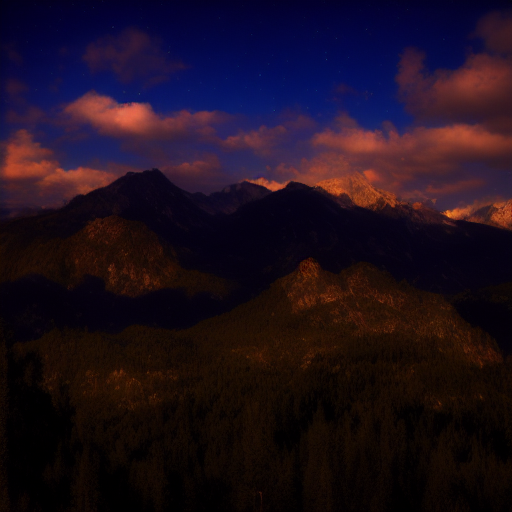

In [6]:
sd_pix = StableDiffusionInstructPix2Pix(img_height=512, 
                                        img_width=512, 
                                        jit_compile=False) # You can try True as well (different performance profile)

edited_img = sd_pix.pix_to_pix(prompt = "make it night", 
                               image = image, 
                               image_guidance_scale=5.0, 
                               num_steps=100)

pil_img = PIL.Image.fromarray(edited_img[0])

pil_img

100/100 [==============================] - 56s 556ms/step


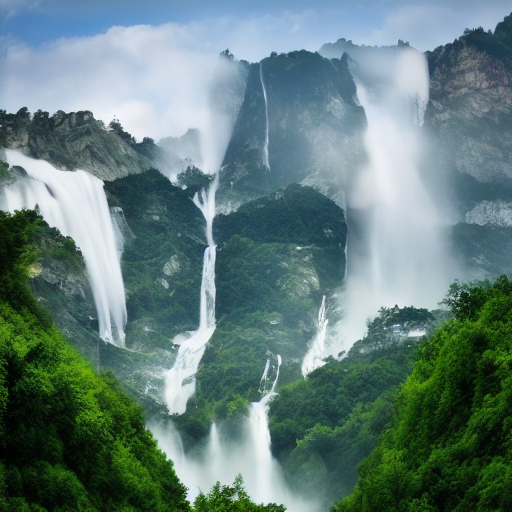

In [8]:
edited_img = sd_pix.pix_to_pix(prompt = "add waterfalls", 
                               image = image, 
                               image_guidance_scale=5.0, 
                               num_steps=100)

pil_img = PIL.Image.fromarray(edited_img[0])

pil_img